![DSME-logo](./img/DSME_logo.png)

#  Reinforcement Learning and Learning-based Control

<p style="font-size:12pt";> 
<b> Prof. Dr. Sebastian Trimpe, Dr. Friedrich Solowjow </b><br>
<b> Institute for Data Science in Mechanical Engineering (DSME) </b><br>
<a href = "mailto:rllbc@dsme.rwth-aachen.de">rllbc@dsme.rwth-aachen.de</a><br>
</p>

---

# Linear Quadratic Regulator for Cartpole Control

![cartpole](./img/cartpole.png)

In this notebook we take a look at the Linear Quadratic Regulator (LQR) applied to the cartpole depicted above. <br> 
The cartpole has the coordinates $x$ and $\theta$, cart mass $m_c$, pole mas $m_p$ and pole length $2l$. <br> 
The pole is controlled by applying a force $F$ to the cart. The control task is to balance the pole in an upright position. This represents an unstable equilibrium.

## Imports

In [31]:
import gymnasium as gym
import numpy as np
import control as ct
import math
import custom_envs
import matplotlib.pyplot as plt
from typing import Optional, Union
from IPython.display import Video
from IPython.display import display
from matplotlib.animation import FuncAnimation
from gymnasium import logger, spaces
from gymnasium.envs.classic_control import utils

%matplotlib inline

## Custom Cartpole Environment
As we need to know the system dynamics for doing controller design, the first step is to model the equations of motion for the cartpole system.<br>
Luckily there is a paper available, where someone has already done the job: https://coneural.org/florian/papers/05_cart_pole.pdf

![cart_pole.gif](./img/cart_pole.gif)

To fit the framework we typically use in RL and to visualize controller performance, we combined this formulation with the farama gym cartpole environment: https://gymnasium.farama.org/environments/classic_control/cart_pole/ 

In [32]:
env = gym.make('CustomCartPole-v1', render_mode='rgb_array')

/opt/homebrew/Caskroom/miniconda/base/envs/rllbc-library/lib/python3.10/site-packages/gymnasium/envs/registration.py:555: UserWarning: WARN: The environment CustomCartPole-v1 is out of date. You should consider upgrading to version `v2`.
  logger.warn(


## Linearize System
For controller synthesis we will make use of the Python Control Systems Library.
If you are interested in looking deeper into this, a good tutorial by Richard Murray can be found here: https://www.cds.caltech.edu/~murray/courses/cds112/wi2023/W1_python-control.pdf <br>
First, we simply incorporate the nonlinear equations of motion of the cartpole system, we used in the cartpole environment into a nonlinear control system. <br>
For LQR synthesis, however, we need a LTI (linear time-invariant) system. The equations of motion are already time-invariant, as they don't depend on the time. But we need to linearize them. The linear system representation we choose is a state space model of the form: $\dot{x}=A x+B u$ <br>
Therfore, we define the control as the force acting on the cart $u = F$ <br>
and the state as the cart position, the pole angle and their first derivative 
<br> $x=\left(\begin{array}{l}x \\ \dot{x} \\ \theta \\ \dot{\theta}\end{array}\right)$ <br>
Consequently, our control system will look like this 
<br> $\left(\begin{array}{c}\dot{x} \\ \ddot{x} \\ \dot{\theta} \\ \ddot{\theta}\end{array}\right)=\left(\begin{array}{llll}a_{11} & a_{12} & a_{13} & a_{14} \\ a_{21} & a_{22} & a_{23} & a_{24} \\ a_{31} & a_{32} & a_{33} & a_{34} \\ a_{41} & a_{42} & a_{43} & a_{44}\end{array}\right)\left(\begin{array}{l}x \\ \dot{x} \\ \theta \\ \dot{\theta}\end{array}\right)+\left(\begin{array}{l}b_1 \\ b_2 \\ b_3 \\ b_4\end{array}\right) F$ <br>
So the angluar acceleration of the pole will be descibed like this: <br>
$\ddot{\theta}=a_{41} x+a_{42} \dot{x}+a_{43} \theta+a_{44} \dot{\theta}+b_4 F$ <br>
We derive those linear coefficients by performing a first order Talyor approximation $T_1$ on the nonlinear equations of motion <br>
$ T_1 f\left(x, x_0\right)=f\left(x_0\right)+\frac{\partial f(x)}{\partial x}\left(x-x_0\right) +\frac{\partial f(x)}{\partial \dot{x}}\left(\dot{x}-\dot{x}_0\right)+\frac{\partial f(x)}{\partial \theta}\left(\theta-\theta_0\right) +\frac{\partial f(x)}{\partial \dot{\theta}}\left(\dot{\theta}-\dot{\theta}_0\right)$<br>
In fact, the *linearize* function does this for us. We only need to provide a state to linearize around, we choose the upper euqilibrium of the cart pole, where the cart is at the origin, the pole stands upright and nothing moves. This corresponds to all state variables being 0.<br>
As we do control in discrete time, we need to reformulate the system matrices, such that we result in a model formulation of
<br>$x_{t+1}=A_d x_t+B_d u_t$. <br>
The *sample* function does this for us.


In [33]:
cartpole = ct.NonlinearIOSystem(env.ct_sys_update, env.ct_sys_output, states=4, name='cartpole', inputs=['action'], outputs=['x', 'x_dot', 'theta', 'theta_dot'])
linsys = cartpole.linearize(x0=np.array([0., 0., 0., 0.]), u0=np.array([0.]))
linsys_d = linsys.sample(env.tau)

## LQR Synthesis
To stabilize the upper equilibrium, we synthesize a linear quadratic regulator (LQR). The idea is to design an optimal controller, such that cost for each start state $x_t$ <br>
$ J = \sum_{k=t}^{\infty}\left[ x_k^T Q x_k + u_k^T R u_k \right] $ is minimized. <br>
Therefore, we need to fomulate the matrices $Q$ and $R$ that penalize deviations of the state from the equilibrium state and control effort. <br>
The result is a feedback controller $u_t = K x_t$

In [34]:
cost_x = 5
cost_x_dot = 1
cost_theta = 10
cost_theta_dot = 1
cost_control = 1

Q = np.diag([cost_x, cost_x_dot, cost_theta, cost_theta_dot])
R = np.diag([cost_control])

K, _, _ = ct.lqr(linsys_d, Q, R)

Define simulation timesteps and a start state

In [35]:
max_steps = 500
start_state = np.array([0.5, 0, 20 * 2 * math.pi / 360, 0])

Let's use the LQR to control the nonlinear cartpole.

In [36]:
done = False
steps = 0
state, _ = env.reset(start_state=start_state.copy())

cont_arr_lqr = np.zeros(max_steps)
state_arr_lqr = np.zeros([max_steps, 4])

frames = []  # collect rgb_image of agent env interaction

while not done:
    action = -np.matmul(K, state)[0]
    next_state, reward, done, _, _ = env.step(action)
    cont_arr_lqr[steps] = action
    state_arr_lqr[steps, :] = state
    out = env.render()
    frames.append(out)
    state = next_state
    steps += 1
    if steps == max_steps:
        done = True

/opt/homebrew/Caskroom/miniconda/base/envs/rllbc-library/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Visualization of the simulation run.

In [37]:
def create_video(frames, title):
    if all(frame is not None for frame in frames):
        fig = plt.figure(figsize=(10, 6))
        plt.axis('off')
        img = plt.imshow(frames[0])

        def animate(index):
            img.set_data(frames[index])
            # plt.show()
            return [img]
        anim = FuncAnimation(fig, animate, frames=len(frames), interval=10)
        plt.close()
        anim.save(title, writer="ffmpeg", fps=30)

In [38]:
create_video(frames, 'cartpole_lqr.mp4')
Video("cartpole_lqr.mp4", html_attributes="loop autoplay")

## Linearization Error
Now we use the same LQR to control the linearized system from the same start state. <br>
Then we compare the state and control trajectories of the original and the linearized system.

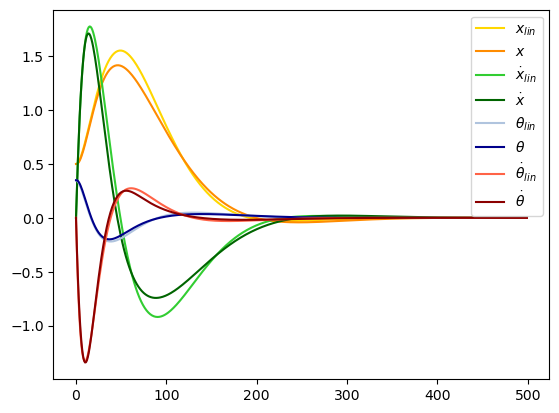

In [39]:
cont_arr_lin_lqr = np.zeros(max_steps)
state_arr_lin_lqr = np.zeros([max_steps, 4])
state = start_state.copy()

for steps in range(max_steps):
    action = -np.matmul(K, state)[0]
    next_state = linsys_d.dynamics(env.tau, state, action)
    cont_arr_lin_lqr[steps] = action
    state_arr_lin_lqr[steps, :] = state
    state = next_state

plt.plot(state_arr_lin_lqr[:, 0], label='$x_{lin}$', color='gold')
plt.plot(state_arr_lqr[:, 0], label='$x$', color='darkorange')
plt.plot(state_arr_lin_lqr[:, 1], label='$\dot{x}_{lin}$', color='limegreen')
plt.plot(state_arr_lqr[:, 1], label='$\dot{x}$', color='darkgreen')
plt.plot(state_arr_lin_lqr[:, 2], label='$\\theta_{lin}$', color='lightsteelblue')
plt.plot(state_arr_lqr[:, 2], label='$\\theta$', color='darkblue')
plt.plot(state_arr_lin_lqr[:, 3], label='$\dot{\\theta}_{lin}$', color='tomato')
plt.plot(state_arr_lqr[:, 3], label='$\dot{\\theta}$', color='darkred')
plt.legend(loc='upper right')
plt.show()

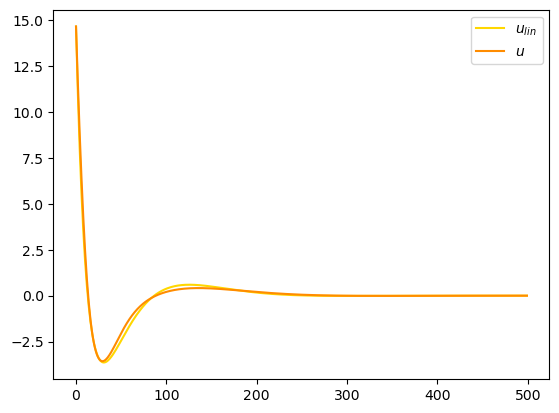

In [40]:
plt.plot(cont_arr_lin_lqr, label='$u_{lin}$', color='gold')
plt.plot(cont_arr_lqr, label='$u$', color='darkorange')
plt.legend(loc='upper right')
plt.show()

We see deviations that are attributed to the linearization error we make. However, due to feedback control, the LQR is capable of stabilizing the nonlinear cartpole.

## Feedforward Control
Let's now try feedforward control. Here, instead of reacting to the current state of the system, we use a precomputed control sequence to stabilize the cartpole.<br>
For the computation of this control sequence we rely on our prior knowledge about the linearized system. Hence we use the precomputed LQR sequence on the linearized system.

In [41]:
max_steps = 500

done = False
steps = 0
state, _ = env.reset(start_state=start_state.copy())

cont_arr_ff = np.zeros(max_steps)
state_arr_ff = np.zeros([max_steps, 4])

frames = []  # collect rgb_image of agent env interaction

while not done:
    action = cont_arr_lin_lqr[steps]
    next_state, reward, done, _, _ = env.step(action)
    cont_arr_ff[steps] = action
    state_arr_ff[steps, :] = state
    out = env.render()
    frames.append(out)
    state = next_state
    steps += 1
    if steps == max_steps:
        done = True

We see in this case, the controller fails as there is no compensation of errors.

In [42]:
create_video(frames, 'cartpole_feedforward.mp4')
Video("cartpole_feedforward.mp4", html_attributes="loop autoplay")

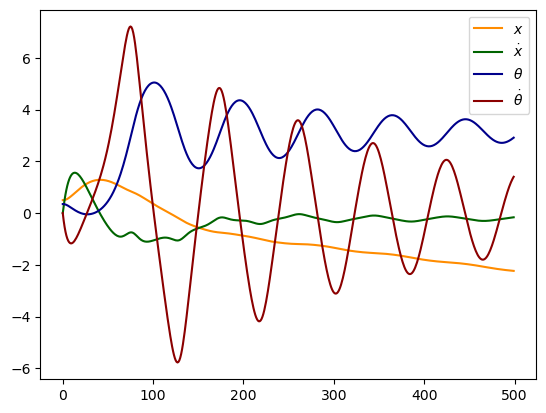

In [43]:
plt.plot(state_arr_ff[:, 0], label='$x$', color='darkorange')
plt.plot(state_arr_ff[:, 1], label='$\dot{x}$', color='darkgreen')
plt.plot(state_arr_ff[:, 2], label='$\\theta$', color='darkblue')
plt.plot(state_arr_ff[:, 3], label='$\dot{\\theta}$', color='darkred')
plt.legend(loc='upper right')
plt.show()

However, we see that feedforward control is not only a problem in case of linearization errors. <br>
It works, if we use the exact same system and start state again.

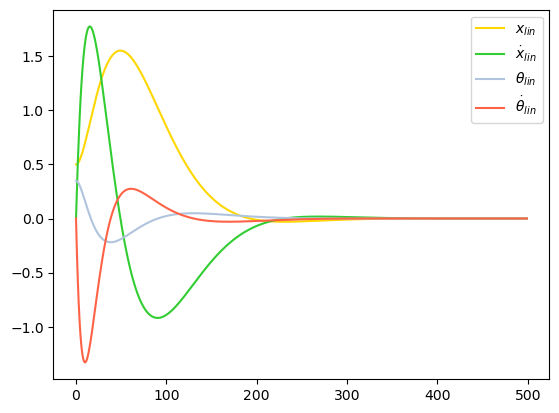

In [44]:
cont_arr_lin_ff = np.zeros(max_steps)
state_arr_lin_ff = np.zeros([max_steps, 4])
state = start_state.copy()

for steps in range(max_steps):
    action = cont_arr_lin_lqr[steps]
    next_state = linsys_d.dynamics(env.tau, state, action)
    cont_arr_lin_ff[steps] = action
    state_arr_lin_ff[steps, :] = state
    state = next_state

plt.plot(state_arr_lin_ff[:, 0], label='$x_{lin}$', color='gold')
plt.plot(state_arr_lin_ff[:, 1], label='$\dot{x}_{lin}$', color='limegreen')
plt.plot(state_arr_lin_ff[:, 2], label='$\\theta_{lin}$', color='lightsteelblue')
plt.plot(state_arr_lin_ff[:, 3], label='$\dot{\\theta}_{lin}$', color='tomato')
plt.legend(loc='upper right')
plt.show()

But as soon as we have a slight change in the initial conditions, the feedforward controller fails again </br>
The same would be true in case of noise or slight modelling errors of the linear system.

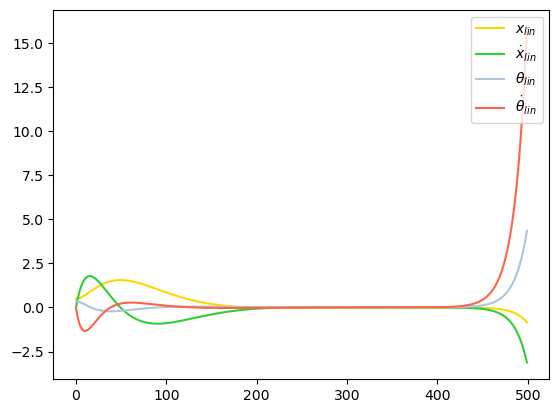

In [45]:
cont_arr_lin_ff = np.zeros(max_steps)
state_arr_lin_ff = np.zeros([max_steps, 4])
state = start_state.copy()+np.array([0., 0., 1e-15, 0.])

for steps in range(max_steps):
    action = cont_arr_lin_lqr[steps]
    next_state = linsys_d.dynamics(env.tau, state, action)
    cont_arr_lin_ff[steps] = action
    state_arr_lin_ff[steps, :] = state
    state = next_state

plt.plot(state_arr_lin_ff[:, 0], label='$x_{lin}$', color='gold')
plt.plot(state_arr_lin_ff[:, 1], label='$\dot{x}_{lin}$', color='limegreen')
plt.plot(state_arr_lin_ff[:, 2], label='$\\theta_{lin}$', color='lightsteelblue')
plt.plot(state_arr_lin_ff[:, 3], label='$\dot{\\theta}_{lin}$', color='tomato')
plt.legend(loc='upper right')
plt.show()